In [ ]:
pip install requests pandas

In [2]:
import requests
import pandas as pd

API_KEY = "d93ce923e1e8438092beece3cf77fae5"
headers = {"X-Auth-Token": API_KEY}

url_table = "https://api.football-data.org/v4/competitions/PL/standings"
resp_table = requests.get(url_table, headers=headers)

if resp_table.status_code == 200:
    data_table = resp_table.json()
    standings = data_table["standings"][0]["table"]

    df_table = pd.DataFrame([{
        "Position": t["position"],
        "Team": t["team"]["name"],
        "Played": t["playedGames"],
        "Won": t["won"],
        "Draw": t["draw"],
        "Lost": t["lost"],
        "Goals For": t["goalsFor"],
        "Goals Against": t["goalsAgainst"],
        "Points": t["points"]
    } for t in standings])

    df_table["GD"] = df_table["Goals For"] - df_table["Goals Against"]
    df_table["Win Rate %"] = (df_table["Won"] / df_table["Played"] * 100).round(1)
    df_table["Points/Game"] = (df_table["Points"] / df_table["Played"]).round(2)
    df_table["Goals/Game (For)"] = (df_table["Goals For"] / df_table["Played"]).round(2)
    df_table["Goals/Game (Against)"] = (df_table["Goals Against"] / df_table["Played"]).round(2)
    df_table["Offensive Power"] = (df_table["Goals For"] / (df_table["Goals For"] + df_table["Goals Against"])).round(2)
    df_table["Defensive Efficiency"] = (df_table["Points"] / df_table["Goals Against"]).round(2)
    print("\n Premier League Table")
    print(df_table)
else:
    print("Error fetching standings:", resp_table.status_code, resp_table.text)


url_scorers = "https://api.football-data.org/v4/competitions/PL/scorers"
resp_scorers = requests.get(url_scorers, headers=headers)

if resp_scorers.status_code == 200:
    data_scorers = resp_scorers.json()
    scorers = data_scorers.get("scorers", [])

    df_scorers = pd.DataFrame([{
        "Player": s["player"]["name"],
        "Team": s["team"]["name"],
        "Goals": s["goals"],
        "Assists": s.get("assists", 0),
        "Matches": s["playedMatches"]
    } for s in scorers])
    df_scorers["Goals/Match"] = (df_scorers["Goals"] / df_scorers["Matches"]).round(2)
    df_scorers["Assist/Match"] = (df_scorers["Assists"] / df_scorers["Matches"]).round(2)
    df_scorers["G+A/Match"] = ((df_scorers["Goals"] + df_scorers["Assists"]) / df_scorers["Matches"]).round(2)
    df_scorers["Goals Share"] = (df_scorers["Goals"] / (df_scorers["Goals"] + df_scorers["Assists"])).round(2)
    df_scorers["GII"] = ((df_scorers["Goals"] * 2 + df_scorers["Assists"]) / df_scorers["Matches"]).round(2)

    if 'df_table' in locals():
        df_scorers = df_scorers.merge(df_table[["Team", "Goals For"]], on="Team", how="left")
        df_scorers["Team Goal Share %"] = (df_scorers["Goals"] / df_scorers["Goals For"] * 100).round(1)
    else:
        df_scorers["Team Goal Share %"] = None

    print("\n Top Premier League Scorers with Advanced Metrics")
    print(df_scorers)

    df_scorers.to_csv("premier_league_scorers_metrics.csv", index=False)
    print("\n Saved: premier_league_scorers_metrics.csv")
else:
    print("Error fetching scorers:", resp_scorers.status_code, resp_scorers.text)





 Premier League Table
    Position                        Team  Played  Won  Draw  Lost  Goals For  \
0          1                  Arsenal FC       8    6     1     1         15   
1          2          Manchester City FC       8    5     1     2         17   
2          3             AFC Bournemouth       8    4     3     1         14   
3          3                Liverpool FC       8    5     0     3         14   
4          5                  Chelsea FC       8    4     2     2         16   
5          6        Tottenham Hotspur FC       8    4     2     2         14   
6          7              Sunderland AFC       8    4     2     2          9   
7          8           Crystal Palace FC       8    3     4     1         12   
8          9        Manchester United FC       8    4     1     3         11   
9         10   Brighton & Hove Albion FC       8    3     3     2         12   
10        11              Aston Villa FC       8    3     3     2          8   
11        12     

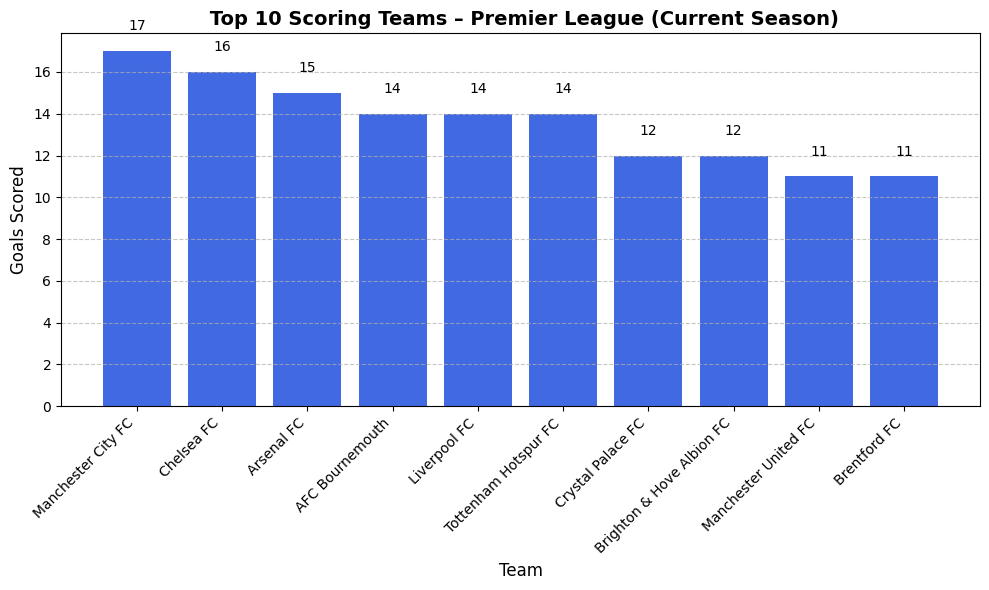

In [4]:
import matplotlib.pyplot as plt

if 'df_table' in locals():
    top10_teams = df_table.sort_values(by="Goals For", ascending=False).head(10)

    plt.figure(figsize=(10,6))
    plt.bar(top10_teams["Team"], top10_teams["Goals For"], color='royalblue')

    plt.title(" Top 10 Scoring Teams – Premier League (Current Season)", fontsize=14, weight='bold')
    plt.xlabel("Team", fontsize=12)
    plt.ylabel("Goals Scored", fontsize=12)
    plt.xticks(rotation=45, ha='right')

    for i, v in enumerate(top10_teams["Goals For"]):
        plt.text(i, v + 1, str(v), ha='center', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(" DataFrame df_table не найден. Сначала запусти блок с API-запросом.")


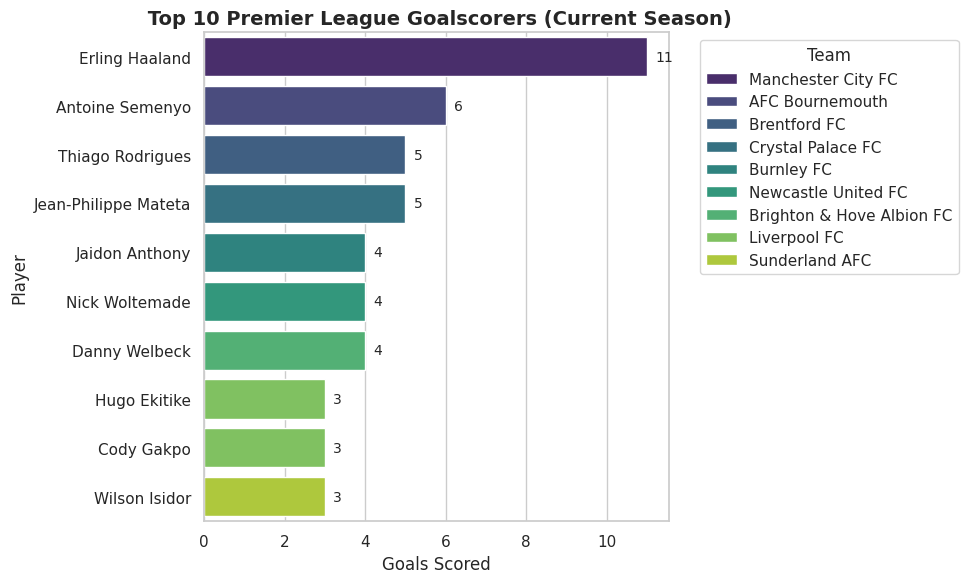

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

if 'df_scorers' in locals():
    top10_scorers = df_scorers.sort_values(by="Goals", ascending=False).head(10)

    plt.figure(figsize=(10,6))
    sns.set_theme(style="whitegrid")

    bar = sns.barplot(
        data=top10_scorers,
        x="Goals",
        y="Player",
        hue="Team",
        dodge=False,
        palette="viridis"
    )

    plt.title(" Top 10 Premier League Goalscorers (Current Season)", fontsize=14, weight='bold')
    plt.xlabel("Goals Scored", fontsize=12)
    plt.ylabel("Player", fontsize=12)
    plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc='upper left')

    for i, (value, name) in enumerate(zip(top10_scorers["Goals"], top10_scorers["Player"])):
        plt.text(value + 0.2, i, str(value), va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print(" DataFrame df_scorers не найден. Сначала запусти API-запрос.")


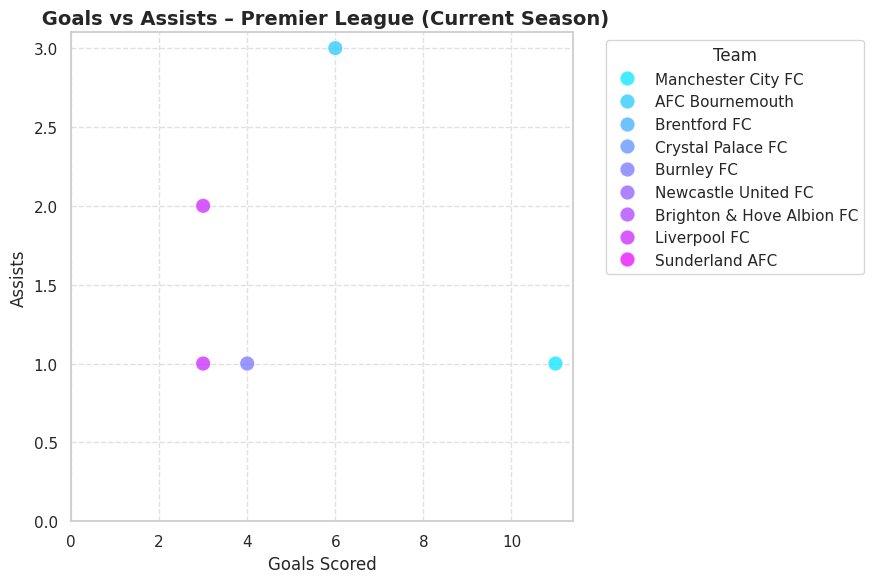

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_scorers' in locals():
    plt.figure(figsize=(9,6))
    sns.set_theme(style="whitegrid")

    scatter = sns.scatterplot(
        data=df_scorers,
        x="Goals", y="Assists",
        hue="Team",
        s=120,
        alpha=0.8,
        palette="cool"
    )

    plt.title(" Goals vs Assists – Premier League (Current Season)", fontsize=14, weight='bold')
    plt.xlabel("Goals Scored", fontsize=12)
    plt.ylabel("Assists", fontsize=12)
    plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.xlim(left=0)
    plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()
else:
    print(" DataFrame df_scorers не найден. Сначала запусти блок с API-запросом.")
